In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("Step4-Logs") \
    .config("spark.executor.memory", "512mb") \
    .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

## PreProcess

In [3]:
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
import re
# import seaborn as sns

#### Sample Logs
29.94.144.152 - - [01/Jul/1995:00:00:13 -0400] "GET / HTTP/1.0" 200 7074

net-1-141.eden.com - - [01/Jul/1995:00:00:19 -0400] "GET /shuttle/missions/sts-71/images/KSC-95EC-0916.jpg HTTP/1.0" 200 34029

205.189.154.54 - - [01/Jul/1995:00:00:40 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 200 786

In [4]:
month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    try:
        return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
        int(text[7:11]),month_map[text[3:6]],int(text[0:2]),
        int(text[12:14]),int(text[15:17]),int(text[18:20]))
    except:
        return None

In [5]:
file_path = '/opt/spark-data/logs/Log'
df = spark.read.csv(file_path, header=False, sep=" ")
df = df.withColumnRenamed('_c0', 'Hosts') \
       .withColumnRenamed('_c1', 'R1') \
       .withColumnRenamed('_c2', 'R2')\
       .withColumnRenamed('_c3', 'Time')\
       .withColumnRenamed('_c4', 'R3')\
       .withColumnRenamed('_c5', 'Request')\
       .withColumnRenamed('_c6', 'Status')\
       .withColumnRenamed('_c7', 'Bytes')
df=df.withColumn('Time', regexp_replace('Time', '\[', ''))
df=df.withColumn('Method', split(df.Request, ' ').getItem(0)) \
       .withColumn('Endpoint', split(df.Request, ' ').getItem(1)) \
       .withColumn('Protocol', split(df.Request, ' ').getItem(2))
udf_parse_time = udf(parse_clf_time)
df = df.withColumn("Time", udf_parse_time(df['Time']).cast('timestamp'))
df = df.withColumn("Date",to_date(col("Time"),"yyyy-MM-dd"))
df = df.drop('R1').drop('R2').drop('R3').drop('Request').drop('Time')
df = df.filter(df.Date.isNotNull())
df.show(5)

+--------------------+------+-----+------+--------------------+--------+----------+
|               Hosts|Status|Bytes|Method|            Endpoint|Protocol|      Date|
+--------------------+------+-----+------+--------------------+--------+----------+
|      129.94.144.152|   200| 7074|   GET|                   /|HTTP/1.0|1995-07-01|
|  net-1-141.eden.com|   200|34029|   GET|/shuttle/missions...|HTTP/1.0|1995-07-01|
|      205.189.154.54|   200|  786|   GET|/images/NASA-logo...|HTTP/1.0|1995-07-01|
|   scheyer.clark.net|   200|49152|   GET|/shuttle/missions...|HTTP/1.0|1995-07-01|
|www-a1.proxy.aol.com|   200| 3985|   GET| /shuttle/countdown/|HTTP/1.0|1995-07-01|
+--------------------+------+-----+------+--------------------+--------+----------+
only showing top 5 rows



In [6]:
df.cache()

Hosts,Status,Bytes,Method,Endpoint,Protocol,Date
129.94.144.152,200,7074,GET,/,HTTP/1.0,1995-07-01
net-1-141.eden.com,200,34029,GET,/shuttle/missions...,HTTP/1.0,1995-07-01
205.189.154.54,200,786,GET,/images/NASA-logo...,HTTP/1.0,1995-07-01
scheyer.clark.net,200,49152,GET,/shuttle/missions...,HTTP/1.0,1995-07-01
www-a1.proxy.aol.com,200,3985,GET,/shuttle/countdown/,HTTP/1.0,1995-07-01
smyth-pc.moorecap...,200,2261,GET,/history/apollo/a...,HTTP/1.0,1995-07-01
port26.annex2.nwl...,200,234,GET,/images/USA-logos...,HTTP/1.0,1995-07-01
gater4.sematech.org,200,3985,GET,/shuttle/countdown/,HTTP/1.0,1995-07-01
remote27.compusma...,302,110,GET,/cgi-bin/imagemap...,HTTP/1.0,1995-07-01
pm13.j51.com,200,305722,GET,/shuttle/missions...,HTTP/1.0,1995-07-01


### Q1

In [7]:
df.select('Hosts').distinct().count()

19243

### Q2

In [8]:
df_grouped = df.groupBy('Hosts','Date').count()
df_avg_req = df_grouped.groupBy('Hosts').avg().withColumnRenamed("avg(count)","Daily_Visit_AVG")
df_avg_req.sort("Daily_Visit_AVG", ascending=False).show(truncate=False)

+----------------------+------------------+
|Hosts                 |Daily_Visit_AVG   |
+----------------------+------------------+
|piweba3y.prodigy.com  |81.42857142857143 |
|alyssa.prodigy.com    |48.142857142857146|
|pcrb.ccrs.emr.ca      |45.0              |
|spidey.cor.epa.gov    |41.0              |
|piweba4y.prodigy.com  |34.5              |
|piweba1y.prodigy.com  |34.42857142857143 |
|hunter.ecs.soton.ac.uk|31.0              |
|burger.letters.com    |30.0              |
|www-b6.proxy.aol.com  |28.142857142857142|
|disarray.demon.co.uk  |28.0              |
|192.77.52.12          |26.0              |
|webgate1.mot.com      |24.5              |
|dip099.pixi.com       |24.0              |
|128.158.21.220        |23.0              |
|piweba2y.prodigy.com  |22.857142857142858|
|dawn14.cs.berkeley.edu|22.0              |
|mica.saglac.qc.ca     |21.0              |
|news.ti.com           |20.428571428571427|
|d202.aa.net           |20.0              |
|134.83.184.18         |20.0    

### Q3

In [40]:
df.filter(df.Endpoint.like('%.gif')&df.Method.like('GET')).count()

25920

### Q4

In [41]:
df_hosts = df.filter(df["Hosts"].rlike('(?:[0-9]{1,3}\.){3}[0-9]{1,3}')==False)
df_ordered = df_hosts.groupby('Hosts').count()
df_ordered = df_ordered.where("count > 3")
df_ordered.sort("count", ascending=False).limit(10).toPandas()

,Hosts,count
0,piweba3y.prodigy.com,570
1,alyssa.prodigy.com,337
2,piweba1y.prodigy.com,241
3,www-b6.proxy.aol.com,197
4,disarray.demon.co.uk,196
5,piweba2y.prodigy.com,160
6,news.ti.com,143
7,www-d4.proxy.aol.com,134
8,poppy.hensa.ac.uk,133
9,advantis.vnet.ibm.com,124


In [42]:
df_hosts = df.filter(df["Hosts"].rlike('(?:[0-9]{1,3}\.){3}[0-9]{1,3}')==False)
df_grouped = df_hosts.groupBy('Hosts','Date').count()
max_day_hosts = (df_grouped.groupBy('Date')\
    .agg(max(struct(col("count"), col("Hosts")))\
    .alias("max")).select(col("Date"), col("max.Hosts"),col("max.count")))
max_day_hosts=max_day_hosts.sort("Date", ascending=False)
max_day_hosts.limit(20).toPandas()

,Date,Hosts,count
0,1995-07-07,piweba3y.prodigy.com,18
1,1995-07-06,piweba3y.prodigy.com,81
2,1995-07-05,piweba3y.prodigy.com,85
3,1995-07-04,piweba3y.prodigy.com,111
4,1995-07-03,piweba3y.prodigy.com,116
5,1995-07-02,piweba3y.prodigy.com,100
6,1995-07-01,piweba3y.prodigy.com,59


### Q5

In [9]:
res_df = df.filter(df['Status']!=200).groupBy('Status').count().collect()
res_df = pd.DataFrame(res_df)
res_df.columns=['Status','Count']

     |████████████████████████████████| 292 kB 108 kB/s eta 0:00:01


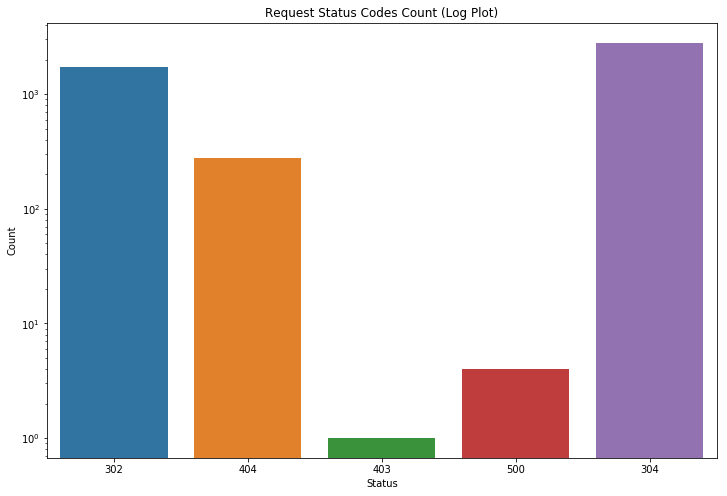

In [10]:
!pip3 install seaborn
import seaborn as sns
plt.figure(figsize=(12,8))
sns.barplot(x='Status',y='Count',data=res_df)
plt.title('Request Status Codes Count (Log Plot)')
plt.yscale('log')

In [11]:
spark.stop()